In [14]:
from itertools import product

import numpy as np
from shapely.geometry import polygon, box

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
plt.set_cmap('magma'); plt.close()

from skimage.measure import regionprops
from skimage.feature import canny
from skimage.filters import threshold_otsu, sobel
from skimage.measure import label
from skimage.segmentation import clear_border, felzenszwalb
from skimage.color import hed_from_rgb, gray2rgb, label2rgb

import secdetect
from skimage.segmentation import watershed
from skimage.io import imread

from tqdm.notebook import tqdm
from skimage.segmentation import slic



In [15]:
def no_crop_to_ring(image, cx, cy, radius):
    """
a function to mask the circle found without cropping to that circle
    :param image: the input image
    :param cx: x coordinate of center circle
    :param cy: y coordinate of center circle
    :param radius: the radius of the circle
    :return:
    """
            # Mask image
    h, w = image.shape[:2]  # get height and width of image
    Y, X = np.ogrid[:h, :w]  # create ogrid over image
    mask = (X - cx)**2 + (Y - cy)**2 > radius**2  # create mask
    image[mask] = 0  # apply mask
    return image

In [16]:
def felz_and_watershed(imagen0, filepath):
    """
Perform felzenszwalb and watershed for instance segmentation and save the segmented image
    :param imagen0: the image number
    :param filepath: the filepath where the image can be found
    """
    imin = imread(filepath + str(imagen0)+ '.png')
    imec = secdetect.enhance_contrast(imin, channel=2, conv_matrix=hed_from_rgb)
    imcn = canny(imec, sigma=4, low_threshold=0.10, high_threshold=0.99, use_quantiles=True)
    cx, cy, r = secdetect.find_ring(imcn)
    

    
    imcr = no_crop_to_ring(imin, cx=cx, cy=cy, radius=r)
    imeccr = no_crop_to_ring(imec, cx=cx, cy=cy, radius=r)

    # Mask with Felzenszwalb segmentation
    imfz = felzenszwalb(imcr, scale=750, sigma=1, min_size=500, multichannel=True)
    imcb = clear_border(imfz, buffer_size=100)
    mask = imcb > 0

    masked_grey = np.where(mask, imeccr, 0)

#    Make segmentation using edge-detection and watershed.
    edges = sobel(masked_grey)
    markers = np.zeros_like(masked_grey)
    fg, bg = 1, 2
    thresh = threshold_otsu(masked_grey)
    markers[masked_grey < thresh] = bg
    markers[masked_grey > thresh] = fg


    # Run watershedding
    ws = watershed(edges, markers, connectivity = 1, compactness = 10, watershed_line = False)
    labels = label(ws == fg)

    # Remove small areas
    labelled = labels.copy()
    (unique, counts) = np.unique(labelled, return_counts = True)
    to_remove = unique[counts < 500]

    for value in to_remove:
       labelled[labelled == value] = 0
    
    plt.imsave(str(imagen0)+'.png', labelled, cmap = 'gray')

In [19]:
def felz_and_SLIC(i, filepath):
    """
Perform felzenszwalb and k-means clustering (SLIC specifically) for instance segmentation and save the segmented image
    :param imagen0: the image number
    :param filepath: the filepath where the image can be found
    """


    imin = imread(filepath+ str(i)+ '.png')
    imec = secdetect.enhance_contrast(imin, channel=2, conv_matrix=hed_from_rgb)
    imcn = canny(imec, sigma=4, low_threshold=0.10, high_threshold=0.99, use_quantiles=True)
    cx, cy, r = secdetect.find_ring(imcn)

    imcr = no_crop_to_ring(imin, cx=cx, cy=cy, radius=r)
    imeccr = no_crop_to_ring(imec, cx=cx, cy=cy, radius=r)

    # Mask with Felzenszwalb segmentation
    imfz = felzenszwalb(imcr, scale=750, sigma=1, min_size=500, multichannel=True)
    imcb = clear_border(imfz, buffer_size=100)
    mask = imcb > 0

    masked_grey = np.where(mask, imeccr, 0)

    # perform k-means clustering using SLIC
    labels = slic(imcr, n_segments = 500, compactness = 20, enforce_connectivity = True)

    labelled = np.where(masked_grey, labels, 0)
    plt.imshow(labelled)

    # Remove small areas
    (unique, counts) = np.unique(labelled, return_counts = True)
    to_remove = unique[counts < 500]

    for value in to_remove:
       labelled[labelled == value] = 0

    plt.imsave(str(i)+'.png', labelled, cmap = 'gray')


image_fp = '../wetransfer-3c006d/_REPOSITORY/png/images_resized1024/'

In [ ]:
# loop through all images, performing felzenszwalb segmentation and watershedding, as used in secdetect

for i in tqdm(range(40)):
    felz_and_watershed(i, image_fp)

  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-19-df7dfd103a66>:19: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  labels = slic(imcr, n_segments = 500, compactness = 20, enforce_connectivity = True)


KeyboardInterrupt: 

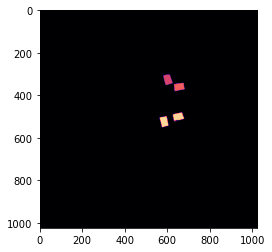

In [20]:
# loop through all images, performing felzenszwalb segmentation and k-means clustering, as used in secdetect

for i in tqdm(range(40)):
    felz_and_SLIC(i, image_fp)